# NLP: Customer Feedback Analysis

A new commercial tool that collects customer feedback from various sources including website, mobile app and social media has been released. The Head of Customer Experience has approached you, seeking to gain deeper insights into the customer feedback. They want to know more about customer satisfaction levels and have tasked you with conducting an analysis to identify key topics discussed in the customer feedback data (reviews.json), as well as classifying the sentiment of the reviews as positive, negative, or neutral.

## Data Description

- **datetime**: date and time recorded
- **review**: the actual review of the customer
- **rating**: rating from the customer
- **agent_response**: response given from an agent
- **review_id**: a unique id for each review


`Task:` </br>
- Conduct a topic clustering analysis on the customer feedback data to determine the main themes and topics discussed in the reviews.
- Develop a supervised sentiment model and evaluate its efficiency on the provided data.


In [1]:
!pip install transformers

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=79789431940d97d2cc3d2efa7973c0a24b64099cb1ac9d8bfc60c9b46f16396c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

## Initial Data Exploration

In [3]:
# Get the dataset into a pandas dataframe
df = pd.read_json('reviews.json')

df.head()

,datetime,review,rating,agent_response,review_id
0,2022-09-02T12:00:00,"The online banking system is fantastic, very u...",5,None,2.125057e+38
1,2022-09-04T17:30:00,I had an issue with my credit card and the cus...,2,None,1.053597e+38
2,2022-10-06T10:45:00,I recently took out a car loan and the interes...,4,None,8.201099e+37
3,2022-10-10T15:00:00,The ATM machines always seem to have plenty of...,5,None,6.915430e+37
4,2022-11-05T08:00:00,The customer service team is always so friendl...,5,None,1.818915e+38


In [4]:
# Drop columns that don't give any value for our tasks
df_cleaned = df.drop(columns = ['datetime', 'agent_response','review_id'])

In [5]:
df_cleaned.head()

,review,rating
0,"The online banking system is fantastic, very u...",5
1,I had an issue with my credit card and the cus...,2
2,I recently took out a car loan and the interes...,4
3,The ATM machines always seem to have plenty of...,5
4,The customer service team is always so friendl...,5


## Topic Clustering Analysis using LDA

### Data Preprocessing

In [6]:
# Drop ratings columns as we are only interested in text at this point
data_TCA = df_cleaned.drop(columns= ['rating'])

# Text preprocessing
nltk.download('punkt')  # Download the necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and initialize lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Create functions that performs the preprocessing
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert text to lowercase
    text = text.lower()

    # Tokenize text into words
    words = word_tokenize(text)

    # Remove stopwords and perform lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the words back into a cleaned text
    cleaned_text = ' '.join(words)

    return cleaned_text

# Apply text preprocessing to the dataset
data_TCA['Cleaned_Review'] = data_TCA['review'].apply(preprocess_text)

# Create a vectorizer (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(data_TCA['Cleaned_Review'].values.astype(str))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### LDA

In [7]:
# Apply LDA
num_topics = 10  # Number of topics that we want to know
lda_model = LatentDirichletAllocation(n_components=num_topics)
lda_model.fit(X_train_vectorized)

# Functions that interprets the topics
def get_top_words(model, feature_names, n_top_words):
    topic_word_list = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_word_list.append(top_words)
    return topic_word_list

n_top_words = 3  # Number of words to show for each topic
feature_names = vectorizer.get_feature_names_out()
topic_words = get_top_words(lda_model, feature_names, n_top_words)

# Print the topics and associated words
for topic_idx, words in enumerate(topic_words):
    print(f"Topic {topic_idx + 1}: {' '.join(words)}")

Topic 1: disappointing horrible ridiculous
Topic 2: im bank coverage
Topic 3: notification transaction amazing
Topic 4: poor terrible center
Topic 5: installment standing order
Topic 6: app bank feature
Topic 7: notification extremely atm
Topic 8: service customer great
Topic 9: accessibility inflation appreciate
Topic 10: increase rate gr8


## Sentiment Analysis

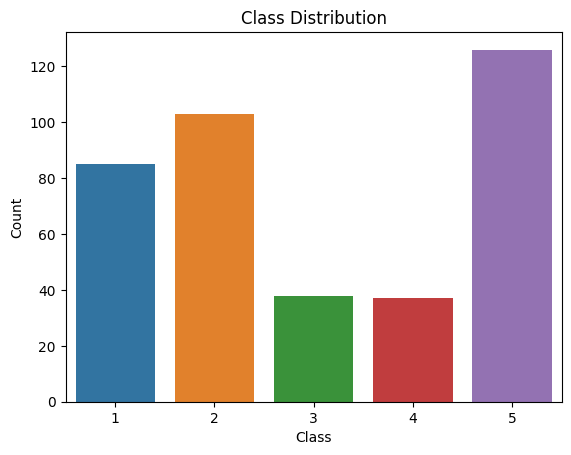

In [8]:
sns.countplot(data=df_cleaned, x='rating')

# Add plot labels
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Display the plot
plt.show()

In [9]:
# Define function to plot confusion_matrix
def plot_conf_mat(y_test, y_preds):
    np.set_printoptions(suppress=True)
    unique_labels = np.unique(np.concatenate((y_test, y_preds)))
    conf_mat = confusion_matrix(y_test, y_preds)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(conf_mat,
                     annot=True,
                     fmt='d',
                     cbar=False,
                     annot_kws={"size": 16},
                     xticklabels=unique_labels,
                     yticklabels=unique_labels)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

In [10]:
# Apply text preprocessing to the dataset
df_cleaned['Cleaned_Review'] = df_cleaned['review'].apply(preprocess_text)

# Create a vectorizer (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(df_cleaned['Cleaned_Review'].values.astype(str))

### Baseline Model (Logistic Regression)

Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.58      0.56        12
           2       0.43      0.43      0.43        21
           3       1.00      0.17      0.29        12
           4       0.00      0.00      0.00        10
           5       0.51      0.91      0.66        23

    accuracy                           0.50        78
   macro avg       0.50      0.42      0.39        78
weighted avg       0.50      0.50      0.44        78



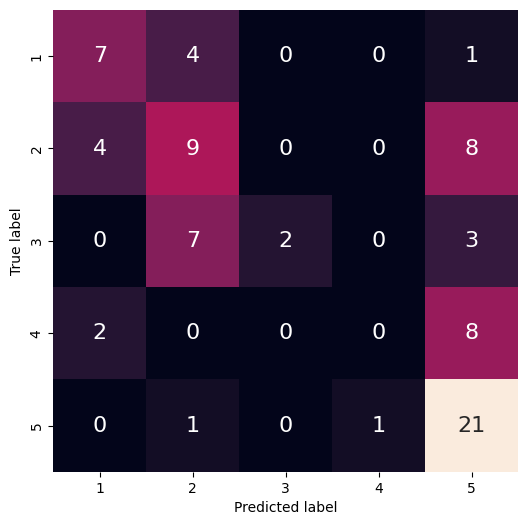

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['Cleaned_Review'], df_cleaned['rating'], test_size=0.2)

# Create a vectorizer (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Build a classification model
model = LogisticRegression()

# Train the model
model.fit(X_train_vectorized, y_train)

# Evaluate the model
y_pred = model.predict(X_test_vectorized)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report and confusion matrix
print("Classification Report:")
class_rep = classification_report(y_test, y_pred)
print(class_rep)

plot_conf_mat(y_test, y_pred)

### Upsample minority classes

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['Cleaned_Review'], df_cleaned['rating'], test_size=0.2)

# Create a vectorizer (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

minority_classes = [3, 4]

# Apply SMOTE to each minority class separately with a sampling ratio
oversample = SMOTE(sampling_strategy={cls: 60 for cls in minority_classes})

X_train_over, y_train_over = oversample.fit_resample(X_train_vectorized, y_train)

In [13]:
print("Original class distribution in y_train:")
print(y_train.value_counts())

print("Class distribution in y_train after SMOTE:")
print(pd.Series(y_train_over).value_counts())

Original class distribution in y_train:
5    100
2     81
1     70
3     32
4     28
Name: rating, dtype: int64
Class distribution in y_train after SMOTE:
5    100
2     81
1     70
3     60
4     60
Name: rating, dtype: int64


Accuracy: 0.5897435897435898
Classification Report:
              precision    recall  f1-score   support

           1       0.75      0.60      0.67        15
           2       0.60      0.41      0.49        22
           3       0.50      0.67      0.57         6
           4       0.40      0.22      0.29         9
           5       0.58      0.85      0.69        26

    accuracy                           0.59        78
   macro avg       0.57      0.55      0.54        78
weighted avg       0.59      0.59      0.57        78



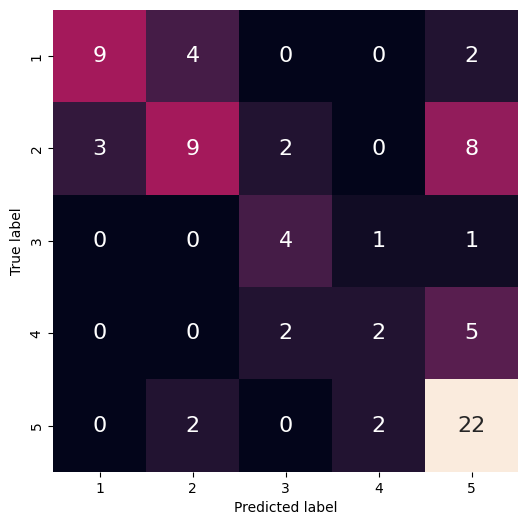

In [14]:
# Build a classification model
model = LogisticRegression()

# Train the model
model.fit(X_train_over, y_train_over)

# Evaluate the model
y_pred2 = model.predict(X_test_vectorized)

# Calculate accuracy
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy2)

# Generate classification report and confusion matrix
print("Classification Report:")
class_rep2 = classification_report(y_test, y_pred2)
print(class_rep2)

plot_conf_mat(y_test, y_pred2)

### Logistic Regression with best parameters

Accuracy: 0.6410256410256411
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.62      0.62        13
           2       0.52      0.61      0.56        23
           3       1.00      0.30      0.46        10
           4       0.50      0.67      0.57         3
           5       0.74      0.79      0.77        29

    accuracy                           0.64        78
   macro avg       0.68      0.60      0.60        78
weighted avg       0.68      0.64      0.63        78



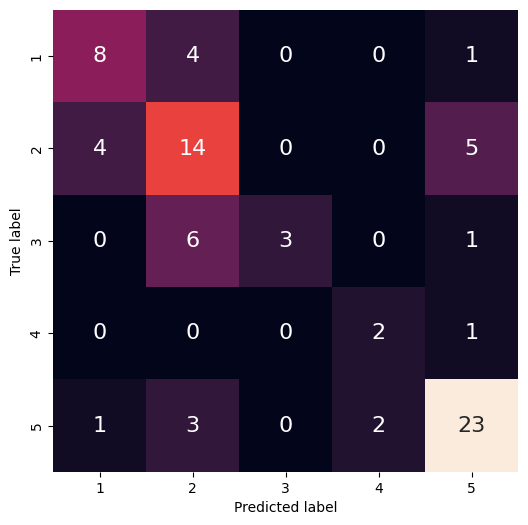

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['Cleaned_Review'], df_cleaned['rating'], test_size=0.2)

# Create a vectorizer (TF-IDF)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Build a classification model
model = LogisticRegression(C = 10, solver= 'liblinear')

# Train the model
model.fit(X_train_vectorized, y_train)

# Evaluate the model
y_pred3 = model.predict(X_test_vectorized)

# Calculate accuracy
accuracy3 = accuracy_score(y_test, y_pred3)
print("Accuracy:", accuracy3)

# Generate classification report and confusion matrix
print("Classification Report:")
class_rep3 = classification_report(y_test, y_pred3)
print(class_rep3)

plot_conf_mat(y_test, y_pred3)

### Transfer Learning

In [16]:
#  Load Pre-trained BERT model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Data Preparation
texts = df_cleaned['Cleaned_Review'].values.tolist()  # Convert to a list of strings
labels = df_cleaned['rating'].values

labels = labels - 1

# Split the data into training and testing sets
X_train_texts, X_test_texts, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenize and encode the input data for both training and testing sets
X_train_inputs = tokenizer(X_train_texts, padding=True, truncation=True, return_tensors='tf')
X_test_inputs = tokenizer(X_test_texts, padding=True, truncation=True, return_tensors='tf')

# Convert to numpy arrays
X_train_inputs = {k: np.array(v) for k, v in X_train_inputs.items()}
X_test_inputs = {k: np.array(v) for k, v in X_test_inputs.items()}

# Fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Fit the model
model.fit(X_train_inputs, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluation
y_pred_tl = model.predict(X_test_inputs)['logits']
y_pred_labels = tf.argmax(y_pred_tl, axis=1)
accuracy4 = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy4)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
9/9 [==============================] - 86s 874ms/step - loss: 1.6026 - accuracy: 0.1900 - val_loss: 1.5118 - val_accuracy: 0.3438
Epoch 2/5
9/9 [==============================] - 4s 429ms/step - loss: 1.5010 - accuracy: 0.3871 - val_loss: 1.3781 - val_accuracy: 0.5000
Epoch 3/5
9/9 [==============================] - 4s 454ms/step - loss: 1.4252 - accuracy: 0.4695 - val_loss: 1.2868 - val_accuracy: 0.6875
Epoch 4/5
9/9 [==============================] - 4s 503ms/step - loss: 1.2898 - accuracy: 0.5878 - val_loss: 1.2080 - val_accuracy: 0.6875
Epoch 5/5
3/3 [==============================] - 3s 101ms/step
Accuracy: 0.5897435897435898


Accuracy: 0.5897435897435898
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        15
           1       0.50      0.48      0.49        21
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.67      0.93      0.78        28

    accuracy                           0.59        78
   macro avg       0.34      0.41      0.37        78
weighted avg       0.48      0.59      0.52        78



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


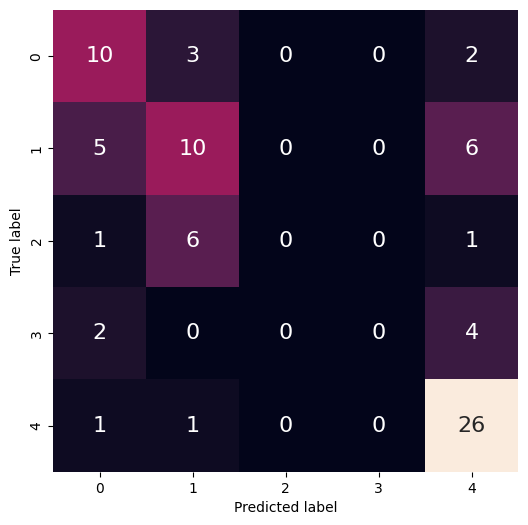

In [17]:
# Calculate accuracy
accuracy4 = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy4)

# Generate classification report and confusion matrix
print("Classification Report:")
class_rep4 = classification_report(y_test, y_pred_labels)
print(class_rep4)

plot_conf_mat(y_test, y_pred_labels)

## Results

### Clustering Analysis

After the clustering analysis performed, the model developed presented the top 10 most discussed topics.

- Topic 1: Notifications disabled
- Topic 2: App user friendly notifications
- Topic 3: Bank disappointment
- Topic 4: Impressingly good cards
- Topic 5: Accessibility malfunctioned issue
- Topic 6: Terrible service wait
- Topic 7: Bank app notification
- Topic 8: Loan order standing
- Topic 9: Banking great web
- Topic 10: Poor security measure

Notable is the interest regarding the notifications of the mobile application, it recieves both positive and negative reviews.

### Sentiment Classification

After experimentation it concludes that the best model for classifing this data is **Logistic Regression** after performing grid search in order to find the best possible parameters. </br>
Logistic Regression provided `64.01% accuracy`. While having "only" 64% accuracy and may be seamingly only 14% better than luck, it's important to keep in mind that the problem we are facing is **multiclass classification**. So, the luck baseline is 20%. </br>
Worth mentioning is a fine tuned deep learning model trained called **BERT**. BERT is a language model which utilize the cutting edge **Transformers** technology, however in our problem the results weren't good enough. With a larger dataset, this model could have promising results, as the examples of certain classes were so few that the model could not manage to learn those classes at all.